# Compute statistical results of the experiment

The goal of this notebook is to load results obtain from the graph matching algorithms coded in matlab (that were given previously simulated graphs) and to compute statistics about these results

## Load the libraries

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import pickle


Bad key "text.kerning_factor" on line 4 in
/Users/Nathan/anaconda3/envs/slam/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load the data

In [85]:
# Get the path to the folder
path = "generated_graphs_big/"

We will load the data in a 3 dimensional tensor where the first dimension correspond to the noise parameter, the second to the outliers parameter and the third one to the different runs for a given set of parameters. First we need to give to each possible value of a parameter an integer value.

In [86]:
# We first go through all files to determine the parameters that were
# chosen and assign an integer to them

def get_noise_and_outliers_params(path_to_folder, number_parameters=2):
    """ go through all the folders to determine the possible
        parameters and assign them an integer value
    """
    
    result = {}
    
    for folder_name in os.listdir(path_to_folder):
        list_splitted = folder_name.split(",")
        
        for param_num, elem_param in enumerate(list_splitted):
            param_name, param_value = elem_param.split("_")
            param_value = float(param_value)
            
            # Create the parameter entries in the result
            if param_name not in result:
                result[param_name] = []
                
            if param_value not in result[param_name]: 
                result[param_name].append(param_value)
            
    # We sort the dict for later plotting purposes
    for param_name in result:
        result[param_name].sort()
        
    return result


dict_parameters_correspondence = get_noise_and_outliers_params(path)

We now need to go through all the folder and build the 3D tensors that will hold the result. But first we need to define an accuracy metric.

In [4]:
def get_accuracy_permutation(target_permutation, given_permutation, use_precision=False):
    """ Return the accuracy of a given permutation knowing the ground truth permutation
        - ground_truth_permutation is a list where the index corresponds to the node in the first graph
        and the value at this index to the permuted node in the second graph
        - given_permutation is a n*n matrix where lines corresponds to node of the first graph
        and columns to the node of the second graph. A 1 in that matrix means that the two nodes are permuted
    """
    
    count_ok = 0
    for original_node, corresponding_node in enumerate(target_permutation):
        if given_permutation[original_node, corresponding_node] == 1:
            count_ok += 1
        
    # If we want the recall measure
    if not use_precision:
        count_total += len(ground_truth_list)
    else:
        count_total += np.nonzero(sub_permutation)[0].shape[0]
        
    return np.clip(count_ok / count_total, 0, 1)

In [88]:
def get_result_tensor_for_given_algorithm(path_to_folder, param_correspondence_dict, name_of_result_file="X_kergm", transposed=False):
    """Go through all folders and build a 3D tensor that holds
    the accuracy metric for all set of parameters for a given algorithm.
    
    Arguments:
        path_to_folder: The path where the results have been calculated
        param_correspondence_dict: The result of the get_noise_and_outliers_params
    function that give an integer correspondence to each parameter value
        name_of_result_file: The file name to load in each folder (each one
    corresponds to a given algorithm)
    """
    
    # We need to find how many runs were used so we go though the first folder
    nbRuns = len(os.listdir(os.path.join(path_to_folder, os.listdir(path_to_folder)[0])))
    
    # We initialise the final tensor that hold the results
    result_tensor_shape = [len(param_correspondence_dict[param_name]) for param_name in param_correspondence_dict]\
                          + [nbRuns]
    result_tensor = np.zeros(result_tensor_shape)
    
    #We go through all folders
    for parameter_folder in os.listdir(path_to_folder):
        
        # define the new path
        path_parameter_folder = os.path.join(path_to_folder, parameter_folder)
        
        # get the parameters
        splitted_param = parameter_folder.split(",")
        param_1_name, param_1_value = splitted_param[0].split("_")
        param_1_value = float(param_1_value)
        param_1_integer = param_correspondence_dict[param_1_name].index(param_1_value)
        
        param_2_name, param_2_value = splitted_param[1].split("_")
        param_2_value = float(param_2_value)
        param_2_integer = param_correspondence_dict[param_2_name].index(param_2_value)
        
        #print(param_1_name, param_1_value, param_2_name, param_2_value, param_1_integer, param_2_integer)
        
        # We go through all the runs
        for run_i, run_folder in enumerate(os.listdir(path_parameter_folder)):
            
            path_run_folder = os.path.join(path_parameter_folder, run_folder)
            
            # load the ground truth corespondence
            ground_truth = np.load(os.path.join(path_run_folder,"ground_truth.npy"))
            
            # load the algorithm result
            algorithm_res = sio.loadmat(os.path.join(path_run_folder,name_of_result_file+".mat"))["X"]
            
            # transpose it if necessary
            if transposed:
                algorithm_res = np.transpose(algorithm_res)
            
            # get the accuracy result
            accuracy = get_accuracy_permutation(ground_truth, algorithm_res)
            
            # add the result to the tensor
            result_tensor[param_1_integer, param_2_integer, run_i] = accuracy
            
    return result_tensor
    
#kergm_res = get_result_tensor_for_given_algorithm(path, res)
#kergm_res.shape

In [109]:
# Coose the path to the result
path = "generated_graphs_big/"
name_dataset = "big"

#load the dictionary of parameters integer correspondence
dict_parameters_correspondence = get_noise_and_outliers_params(path)

# compute the result of all the given algorithms
transposed = True
kergm_res = get_result_tensor_for_given_algorithm(path, dict_parameters_correspondence, "X_kergm", False)
ipf_res = get_result_tensor_for_given_algorithm(path, dict_parameters_correspondence, "X_ipf", transposed)
rrwm_res = get_result_tensor_for_given_algorithm(path, dict_parameters_correspondence, "X_rrwm", transposed)
smac_res = get_result_tensor_for_given_algorithm(path, dict_parameters_correspondence, "X_smac", transposed)

## Load the data from script

In [2]:
path_to_data = "results/new_simus_complete_recall.pickle"

pickle_in = open(path_to_data,"rb")
dict_results = pickle.load(pickle_in)

# Affect all the necesary variables
dict_parameters_correspondence = dict_results["parameter_correspondence"]
kergm_res = dict_results["kergm"]
ipf_res = dict_results["ipf"]
rrwm_res = dict_results["rrwm"]
smac_res = dict_results["smac"]

## Plot interesting statistics

First we will plot the effect of the noise on the matching

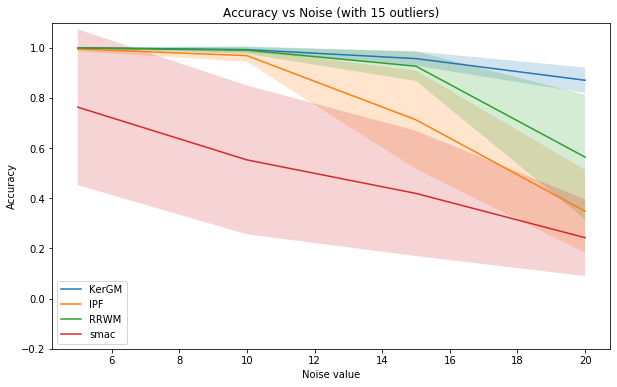

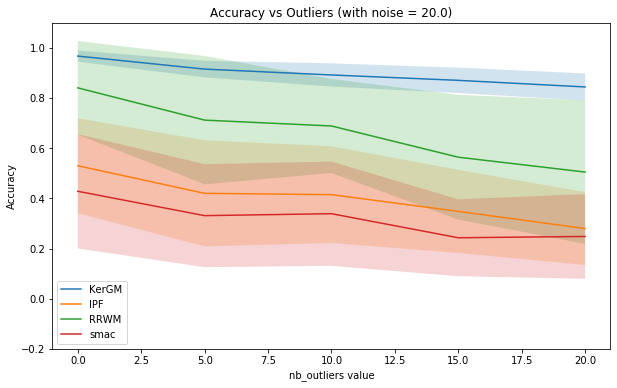

In [88]:
# We choose to plot first the effect of the noise.

name_dataset = "big_2"

# get the interesting data
outliers_constant_integer = 3
x = dict_parameters_correspondence["noise"]
y_kergm = np.mean(kergm_res[:,outliers_constant_integer,:],1)
std_kergm = np.std(kergm_res[:,outliers_constant_integer,:],1)
y_ipf = np.mean(ipf_res[:,outliers_constant_integer,:],1)
std_ipf = np.std(ipf_res[:,outliers_constant_integer,:],1)
y_rrwm = np.mean(rrwm_res[:,outliers_constant_integer,:],1)
std_rrwm = np.std(rrwm_res[:,outliers_constant_integer,:],1)
y_smac = np.mean(smac_res[:,outliers_constant_integer,:],1)
std_smac = np.std(smac_res[:,outliers_constant_integer,:],1)


# plot the curves
plt.figure(figsize=(10,6))
plt.plot(x, y_kergm, label="KerGM", alpha=1)
plt.fill_between(x, y_kergm-std_kergm, y_kergm+std_kergm, alpha=0.2)
plt.plot(x, y_ipf, label="IPF", alpha=1)
plt.fill_between(x, y_ipf-std_ipf, y_ipf+std_ipf, alpha=0.2)
plt.plot(x, y_rrwm, label="RRWM", alpha=1)
plt.fill_between(x, y_rrwm-std_rrwm, y_rrwm+std_rrwm, alpha=0.2)
plt.plot(x, y_smac, label="smac", alpha=1)
plt.fill_between(x, y_smac-std_smac, y_smac+std_smac, alpha=0.2)
plt.xlabel("Noise value")
plt.ylabel("Accuracy")
plt.ylim(-0.2,1.1)
plt.title("Accuracy vs Noise (with "+str(int(dict_parameters_correspondence["outliers"][outliers_constant_integer]))+" outliers)")
plt.legend()
plt.savefig("plots/Accuracy_vs_noise_"+str(name_dataset))


##### Plot the accuracy vs_outlier #####
# get the interesting data
noise_constant_integer = 3
x = dict_parameters_correspondence["outliers"]
y_kergm = np.mean(kergm_res[noise_constant_integer,:,:],1)
std_kergm = np.std(kergm_res[noise_constant_integer,:,:],1)
y_ipf = np.mean(ipf_res[noise_constant_integer,:,:],1)
std_ipf = np.std(ipf_res[noise_constant_integer,:,:],1)
y_rrwm = np.mean(rrwm_res[noise_constant_integer,:,:],1)
std_rrwm = np.std(rrwm_res[noise_constant_integer,:,:],1)
y_smac = np.mean(smac_res[noise_constant_integer,:,:],1)
std_smac = np.std(smac_res[noise_constant_integer,:,:],1)


# plot the curves
plt.figure(figsize=(10,6))
plt.plot(x, y_kergm, label="KerGM", alpha=1)
plt.fill_between(x, y_kergm-std_kergm, y_kergm+std_kergm, alpha=0.2)
plt.plot(x, y_ipf, label="IPF", alpha=1)
plt.fill_between(x, y_ipf-std_ipf, y_ipf+std_ipf, alpha=0.2)
plt.plot(x, y_rrwm, label="RRWM", alpha=1)
plt.fill_between(x, y_rrwm-std_rrwm, y_rrwm+std_rrwm, alpha=0.2)
plt.plot(x, y_smac, label="smac", alpha=1)
plt.fill_between(x, y_smac-std_smac, y_smac+std_smac, alpha=0.2)
plt.xlabel("nb_outliers value")
plt.ylabel("Accuracy")
plt.ylim(-0.2,1.1)
plt.title("Accuracy vs Outliers (with noise = "+str(dict_parameters_correspondence["noise"][noise_constant_integer])+")")
plt.legend()
plt.savefig("plots/Accuracy_vs_outliers_"+str(name_dataset))

================ NOISE ===============


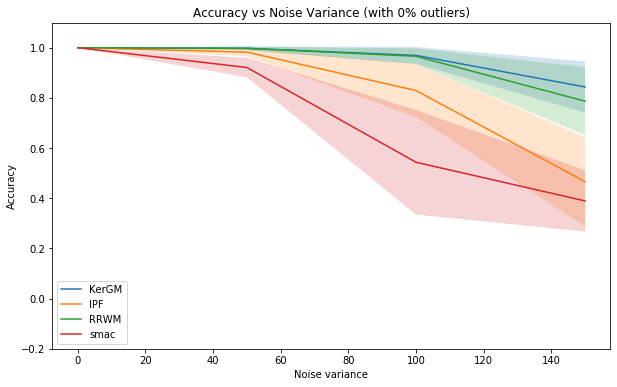

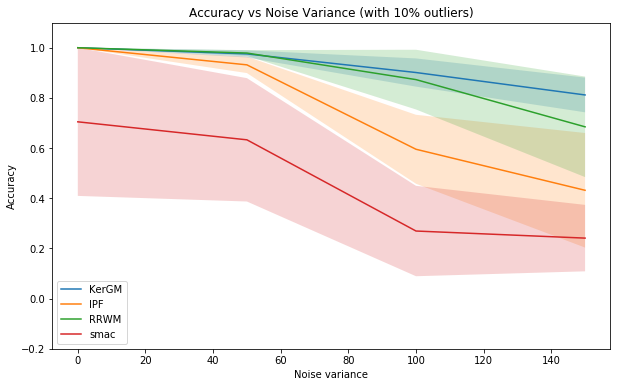

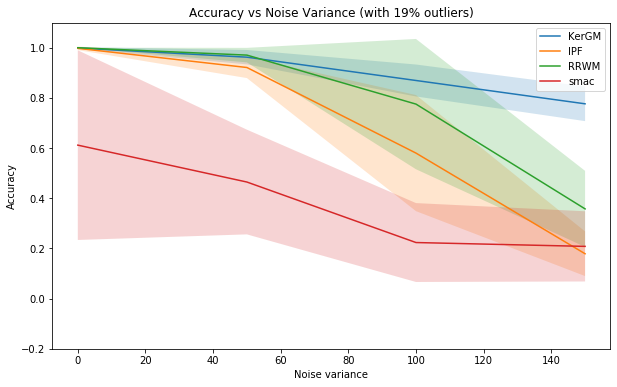

============== OUTLIERS ==============


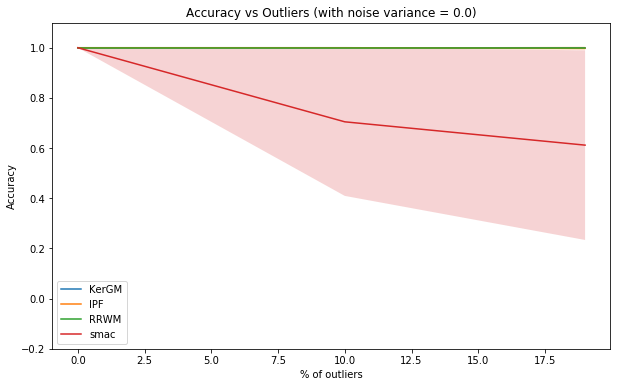

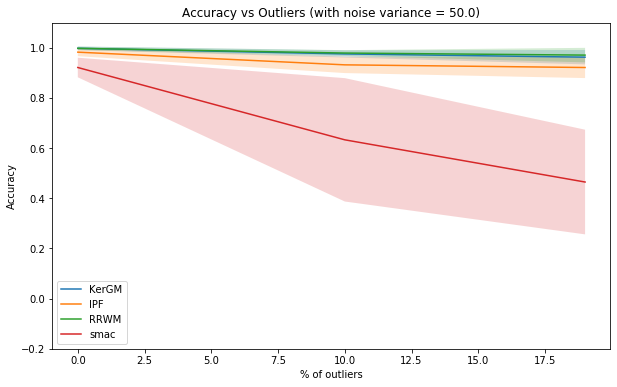

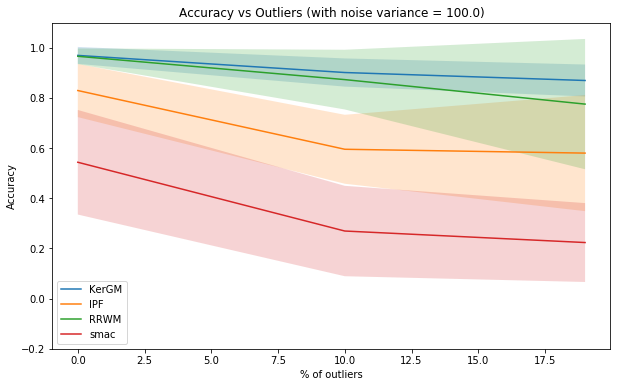

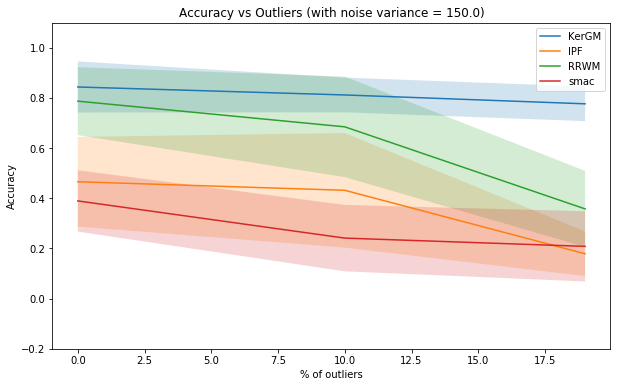

In [3]:
name_dataset = "new_simus_recall"
nb_vertices = 85

print("======================================")
print("================ NOISE ===============")
print("======================================")


for i in range(len(dict_parameters_correspondence["outliers"])):
    
    outliers_constant_integer = i
    nb_outliers = dict_parameters_correspondence["outliers"][i]
    percent_outliers = int(nb_outliers / (nb_vertices + nb_outliers) * 100)
    
    x = dict_parameters_correspondence["noise"]
    y_kergm = np.mean(kergm_res[:,outliers_constant_integer,:],1)
    std_kergm = np.std(kergm_res[:,outliers_constant_integer,:],1)
    y_ipf = np.mean(ipf_res[:,outliers_constant_integer,:],1)
    std_ipf = np.std(ipf_res[:,outliers_constant_integer,:],1)
    y_rrwm = np.mean(rrwm_res[:,outliers_constant_integer,:],1)
    std_rrwm = np.std(rrwm_res[:,outliers_constant_integer,:],1)
    y_smac = np.mean(smac_res[:,outliers_constant_integer,:],1)
    std_smac = np.std(smac_res[:,outliers_constant_integer,:],1)


    # plot the curves
    plt.figure(figsize=(10,6))
    plt.plot(x, y_kergm, label="KerGM", alpha=1)
    plt.fill_between(x, y_kergm-std_kergm, y_kergm+std_kergm, alpha=0.2)
    plt.plot(x, y_ipf, label="IPF", alpha=1)
    plt.fill_between(x, y_ipf-std_ipf, y_ipf+std_ipf, alpha=0.2)
    plt.plot(x, y_rrwm, label="RRWM", alpha=1)
    plt.fill_between(x, y_rrwm-std_rrwm, y_rrwm+std_rrwm, alpha=0.2)
    plt.plot(x, y_smac, label="smac", alpha=1)
    plt.fill_between(x, y_smac-std_smac, y_smac+std_smac, alpha=0.2)
    plt.xlabel("Noise variance")
    plt.ylabel("Accuracy")
    plt.ylim(-0.2,1.1)
    plt.title("Accuracy vs Noise Variance (with {:0d}% outliers)".format(percent_outliers))
    plt.legend()
    plt.savefig("plots/Accuracy_vs_noise_"+str(name_dataset)+"_"+str(int(dict_parameters_correspondence["outliers"][outliers_constant_integer]))+".png")
    plt.plot()
    plt.show()

print("======================================")
print("============== OUTLIERS ==============")
print("======================================")

for i in range(len(dict_parameters_correspondence["noise"])):
    noise_constant_integer = i
    x = dict_parameters_correspondence["outliers"]
    x = [int(nb_outliers / (nb_vertices + nb_outliers) * 100) for nb_outliers in x]
    y_kergm = np.mean(kergm_res[noise_constant_integer,:,:],1)
    std_kergm = np.std(kergm_res[noise_constant_integer,:,:],1)
    y_ipf = np.mean(ipf_res[noise_constant_integer,:,:],1)
    std_ipf = np.std(ipf_res[noise_constant_integer,:,:],1)
    y_rrwm = np.mean(rrwm_res[noise_constant_integer,:,:],1)
    std_rrwm = np.std(rrwm_res[noise_constant_integer,:,:],1)
    y_smac = np.mean(smac_res[noise_constant_integer,:,:],1)
    std_smac = np.std(smac_res[noise_constant_integer,:,:],1)


    # plot the curves
    plt.figure(figsize=(10,6))
    plt.plot(x, y_kergm, label="KerGM", alpha=1)
    plt.fill_between(x, y_kergm-std_kergm, y_kergm+std_kergm, alpha=0.2)
    plt.plot(x, y_ipf, label="IPF", alpha=1)
    plt.fill_between(x, y_ipf-std_ipf, y_ipf+std_ipf, alpha=0.2)
    plt.plot(x, y_rrwm, label="RRWM", alpha=1)
    plt.fill_between(x, y_rrwm-std_rrwm, y_rrwm+std_rrwm, alpha=0.2)
    plt.plot(x, y_smac, label="smac", alpha=1)
    plt.fill_between(x, y_smac-std_smac, y_smac+std_smac, alpha=0.2)
    plt.xlabel("% of outliers")
    plt.ylabel("Accuracy")
    plt.ylim(-0.2,1.1)
    plt.title("Accuracy vs Outliers (with noise variance = "+str(dict_parameters_correspondence["noise"][noise_constant_integer])+")")
    plt.legend()
    plt.savefig("plots/Accuracy_vs_outliers_"+str(name_dataset)+"_"+str(dict_parameters_correspondence["noise"][noise_constant_integer])+".png" )
    plt.show()
    
    

## Function to create plots from different experiments

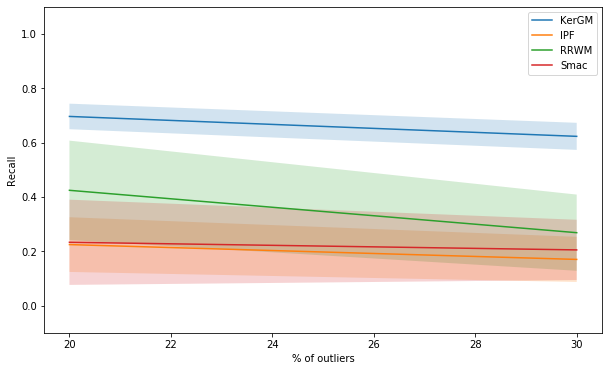

{'kergm': {20.0: 0.6960606060606062, 30.0: 0.6227777777777777},
 'ipf': {20.0: 0.22454545454545455, 30.0: 0.16999999999999998},
 'rrwm': {20.0: 0.42424242424242425, 30.0: 0.26833333333333337},
 'smac': {20.0: 0.233030303030303, 30.0: 0.20500000000000002}}

In [16]:
def plot_from_different_experiments(list_dict_result, x_param="noise", static_param_value=0, name_dataset="full", name_metric="Recall"):
    """ Get the result of different experiments and combine
        them to create a plot for one parameter throughout the experiments
    """
    
    if x_param == "noise":
        static_param = "outliers"
    else:
        static_param = "noise"
    
    name_algorithms = ["kergm","ipf","rrwm","smac"]
    label_corres = {"kergm":"KerGM", "ipf":"IPF", "rrwm":"RRWM", "smac":"Smac"}
    
    # create three lists x, y and err for one plot
    x_final = []
    y_final = {alg_name:{} for alg_name in name_algorithms}
    err_final = {alg_name:{} for alg_name in name_algorithms}
    
    #y_tuple = {alg_name:{} for alg_name in name_algorithms}
    #err_tuple = {alg_name:{} for alg_name in name_algorithms}
    
    
    # We go through all the dict_results and we keep the tuple (x,val)
    for dict_result in list_dict_result:
        
        # We load the data
        dict_parameters_correspondence = dict_result["parameter_correspondence"]
        kergm_res = dict_result["kergm"]
        ipf_res = dict_result["ipf"]
        rrwm_res = dict_result["rrwm"]
        smac_res = dict_result["smac"]
        
        algos_res = [(name, dict_result[name]) for name in name_algorithms]

        # We get the integer value for the static param
        static_param_integer = dict_parameters_correspondence[static_param].index(static_param_value)
        
        # We fill the result dictionaries
        for variable_param_i, variable_param_val in enumerate(dict_parameters_correspondence[x_param]):
            
            for name_alg, dict_res_alg in algos_res:
                
                # We create the entry for the given x if it does not exist :
                if variable_param_val not in y_final[name_alg]:
                    y_final[name_alg][variable_param_val] = []
                    
                if variable_param_val not in err_final[name_alg]:
                    err_final[name_alg][variable_param_val] = []
                    
                # We compute the result
                if x_param == "noise":
                    #print(variable_param_i, static_param_integer, dict_res_alg[variable_param_i,static_param_integer,:])
                    #print(variable_param_i, static_param_integer, dict_res_alg)
                    #y_tmp = np.mean(dict_res_alg[static_param_integer,variable_param_i,:],1)
                    #err_tmp = np.std(dict_res_alg[static_param_integer,variable_param_i,:],1)
                    y_tmp = np.mean(dict_res_alg[variable_param_i,static_param_integer,:])
                    err_tmp = np.std(dict_res_alg[variable_param_i,static_param_integer,:])
                else:
                    y_tmp = np.mean(dict_res_alg[static_param_integer,variable_param_i,:])
                    err_tmp = np.std(dict_res_alg[static_param_integer,variable_param_i,:])
                    
                y_final[name_alg][variable_param_val].append(y_tmp)
                err_final[name_alg][variable_param_val].append(err_tmp)
                
    # Now that we have the numbers we take the mean of the points where there are several values
    for alg_name in y_final:
        for x_val in y_final[alg_name]:
            y_final[alg_name][x_val] = np.mean(y_final[alg_name][x_val])
            err_final[alg_name][x_val] = np.mean(err_final[alg_name][x_val])
            
            
    # We plot everything of interest   
    plt.figure(figsize=(10,6))
    
    for alg_name in y_final:
        x_list = []
        y_list = []
        err_list = []
        
        for x_val in y_final[alg_name]:
            x_list.append(x_val)
            y_list.append(y_final[alg_name][x_val])
            err_list.append(err_final[alg_name][x_val])
            
        y_list = np.array(y_list)
        err_list = np.array(err_list)
        plt.plot(x_list, y_list, label=label_corres[alg_name])
        plt.fill_between(x_list, y_list-err_list, y_list+err_list, alpha=0.2)
       
    if x_param == "noise":
        percent_outliers = int(static_param_value/(90 + static_param_value) * 100)
        plt.xlabel("Noise variance")
        #plt.title("Accuracy vs Noise Variance (with {:0d}% outliers)".format(percent_outliers))
        name_to_save = "plots/"+name_metric+"_vs_noise_"+name_dataset+"_"+str(static_param_value)+".png"

    else:
        x_list = [int(x/(90 + x) * 100) for x in x_list]
        plt.xlabel("% of outliers")
        #plt.title("Accuracy vs Outliers (with noise variance = "+str(static_param_value)+")")
        name_to_save = "plots/"+name_metric+"_vs_outliers_"+name_dataset+"_"+str(static_param_value)+".png"
    
    plt.ylabel(name_metric)
    plt.ylim(-0.1,1.1)
    plt.legend()
    plt.savefig(name_to_save)
    plt.show()
    
    
    return y_final, err_final
                        
a, b = plot_from_different_experiments([dict_results],"outliers",20)
a

In [22]:
pickle_in = open("results/big_2_recall.pickle","rb")
dict_result_2 = pickle.load(pickle_in)

pickle_in = open("results/big_3_recall.pickle","rb")
dict_result_3 = pickle.load(pickle_in)

dict_list = [dict_result_2, dict_result_3]

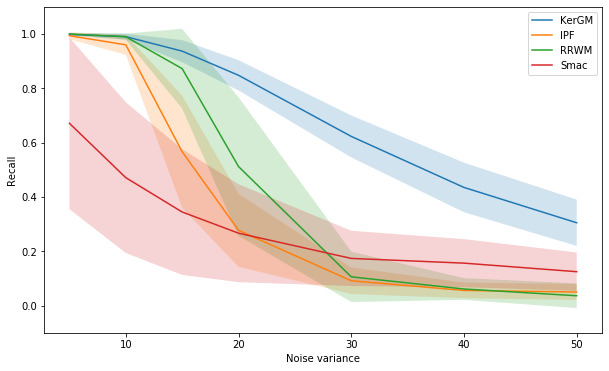

In [23]:
a,b = plot_from_different_experiments(dict_list,"noise",20,name_metric="Recall")
#a